<a href="https://colab.research.google.com/github/JamesLeeeeeee/machineLearning_practice/blob/master/20211126_pytorch_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
torch.cuda.is_available()

True

In [5]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')

In [32]:
device

device(type='cuda')

In [9]:
transform= transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [10]:
trainset= torchvision.datasets.CIFAR10(root='/data',
                                       train=True,
                                       download=True,
                                       transform=transform)
testset= torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [20]:
train_loader= DataLoader(trainset,
                         batch_size=4,
                         shuffle=True,
                         num_workers=2
                         )
test_loader= DataLoader(trainset,
                         batch_size=4,
                         shuffle=False,
                         num_workers=2
                         )

In [21]:
classes= ('plane', 'car','bird','cat','deer','dog','frog','horse','ship','truck')

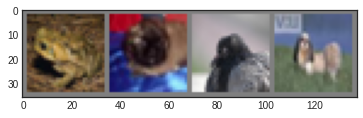

frog		 dog		 bird		 dog		


In [23]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
dataiter=iter(train_loader)
images, labels= dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t\t'.format(classes[labels[j]]) for j in range(4)))

In [33]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1= nn.Conv2d(3,6,5)
    self.pool= nn.MaxPool2d(2,2)
    self.conv2= nn.Conv2d(6,16,5)
    self.fc1= nn.Linear(16*5*5, 120)
    self.fc2= nn.Linear(120,84)
    self.fc3= nn.Linear(84,10)

  def forward(self,x):
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= x.view(-1, 16*5*5)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x
net= Net().to(device)

In [26]:
criterion= nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
for epoch in range(2):
  running_loss=0.0

  for i , data in enumerate(train_loader,0):
    inputs, labels= data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs= net(inputs)
    loss= criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    if i %2000==1999:
      print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss=0.0

Epoch: 1, Batch: 2000, Loss: 2.242868305146694
Epoch: 1, Batch: 4000, Loss: 1.871295183867216
Epoch: 1, Batch: 6000, Loss: 1.6817591636776925
Epoch: 1, Batch: 8000, Loss: 1.5749032465815545
Epoch: 1, Batch: 10000, Loss: 1.524734778687358
Epoch: 1, Batch: 12000, Loss: 1.4601038616746664
Epoch: 2, Batch: 2000, Loss: 1.3983636830300092
Epoch: 2, Batch: 4000, Loss: 1.376623291105032
Epoch: 2, Batch: 6000, Loss: 1.3501811770871281
Epoch: 2, Batch: 8000, Loss: 1.3319705280661582
Epoch: 2, Batch: 10000, Loss: 1.2822946396172046
Epoch: 2, Batch: 12000, Loss: 1.2983007630743086


In [28]:
path='./cifar_net.pth'
torch.save(net.state_dict(),path)


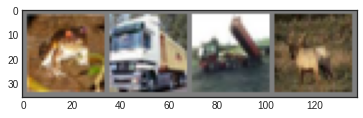

frog		 truck		 truck		 deer		


In [29]:
dataiter= iter(test_loader)
images, labels= dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t\t'.format(classes[labels[j]])for j in range(4)))

In [34]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
outputs= net(images.to(device))

In [36]:
_,predicted= torch.max(outputs, 1)
print(' '.join('{}\t'.format(classes[predicted[j]]) for j in range(4)))

frog	 truck	 truck	 frog	


In [38]:
correct=0
total=0

with torch.no_grad():
  for data in test_loader:
    images, labels= data[0].to(device), data[1].to(device)
    outputs= net(images)
    _,predicted= torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct += (predicted==labels).sum().item()
print(100*correct/total)

58.48


In [42]:
class_correct= list(0. for i in range(10))
class_total= list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels= data[0].to(device), data[1].to(device)
    outputs= net(images)
    _,predicted= torch.max(outputs.data, 1)
    c=(predicted==labels).squeeze()
    for i in range(4):
      label= labels[i]
      class_correct[label]+=c[i].item()
      class_total[label]+=1

for i in range(10):
  print('Accuracy of {}: {}%'.format(classes[i], 100*class_correct[i]/class_total[i]))



Accuracy of plane: 62.6%
Accuracy of car: 82.62%
Accuracy of bird: 39.2%
Accuracy of cat: 48.08%
Accuracy of deer: 46.42%
Accuracy of dog: 36.64%
Accuracy of frog: 73.16%
Accuracy of horse: 65.8%
Accuracy of ship: 68.46%
Accuracy of truck: 61.82%


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]